# Introduction

This is a basic example of using TOAST interactively for LiteBIRD simulations.  This uses an extra package to help displaying things in the notebook.  You can install that with `pip install wurlitzer` and restart this notebook kernel.

In [1]:
# Built-in modules
import sys
import os
from datetime import datetime

# External modules
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import healpy as hp

# LiteBIRD and TOAST tools

import toast
import toast.ops
from toast import schedule_sim_satellite as schedulesim
from toast import pixels_io as pio

import litebirdtask as lbt
from litebirdtask import vis as lbtv
from litebirdtask import ops as lbtops


# Capture C++ output in the jupyter cells
%load_ext wurlitzer

# Display inline plots
%matplotlib inline

## Instrument Data

Specify the location of the instrument / hardware file you downloaded from the wiki (See https://wiki.kek.jp/pages/viewpage.action?pageId=150667506)

In [2]:
hwfile = "/home/kisner/git/litebird/litebird_model_2021-02-15T22:12:51.toml.gz"

### Load the Hardware Model

This loads the full instrument model:

In [3]:
hw = lbt.Hardware(path=hwfile)

### Select Detectors

The file you download from the wiki has **all** detectors.  For this example, we will select just a few of them.

In [4]:
lfhw = hw.select(
    match={
        "wafer": ["L00",],
        "band": ".*040",
        "pixel": "00."
    }
)

We can see which detectors were selected:

In [5]:
lbtv.summary_text(lfhw)

software    :     3 objects
    litebirdms, litebirdtask, toast
pixels      :     2 objects
    LP1, LP2
bands       :     6 objects
    L2-068, L2-050, L1-078, L1-040, L2-089, L1-060
telescopes  :     1 objects
    LFT
wafers      :     1 objects
    L00
detectors   :    12 objects
    L00_003_QA_040T, L00_003_QA_040B, L00_004_QB_040T, L00_004_QB_040B, 
    L00_005_UA_040T, L00_005_UA_040B, L00_006_UA_040T, L00_006_UA_040B, 
    L00_007_UB_040T, L00_007_UB_040B, L00_008_UA_040T, L00_008_UA_040B


## Observing Schedule

Before running the simulation we need to create an "observing schedule".  This is a simple model of stable science scans separated by optional "gaps".  For this example we will make contiguous scans with no gaps.  Here we make a schedule for 1 day of observing, with one-hour stable science scans:

In [6]:
schedule = schedulesim.create_satellite_schedule(
    prefix="LB_",
    mission_start=datetime.fromisoformat("2030-07-07T07:07:07+00:00"),
    observation_time=60 * u.minute,
    gap_time=0 * u.minute,
    num_observations=24, # 1 day x 24 obs per day
    prec_period=3.2058 * u.hour, # From IMOv1 wiki page
    spin_period=20 * u.minute, # From IMOv1 wiki, 0.05 RPM = 20 minutes
)

In [7]:
print(schedule)

<SatelliteSchedule site=space telescope=satellite with 24 scans
  <SatelliteScan 'LB_000000_2030-07-07T07:07+00:00' at 2030-07-07T07:07:07+00:00 with prec period 3.2058 h, spin period 20.0 min>
  <SatelliteScan 'LB_000001_2030-07-07T08:07+00:00' at 2030-07-07T08:07:07+00:00 with prec period 3.2058 h, spin period 20.0 min>
  ... 
  <SatelliteScan 'LB_000022_2030-07-08T05:07+00:00' at 2030-07-08T05:07:07+00:00 with prec period 3.2058 h, spin period 20.0 min>
  <SatelliteScan 'LB_000023_2030-07-08T06:07+00:00' at 2030-07-08T06:07:07+00:00 with prec period 3.2058 h, spin period 20.0 min>
>


We can also write / read this schedule to disk.

## Simulate the Scanning

Next we are going to run a LiteBIRD scanning simulation.  We start with an empty TOAST data container:

In [8]:
data = toast.Data()
print(data)

<Data with 0 Observations:
Metadata:
{}
>


Now we will create a LiteBIRD scanning "Operator" and apply it to the data.  We can always see the help for an operator before we use it:

In [9]:
# This will pop up a help window
#?lbtops.SimScan

In [10]:
# Create the operator

sim_scan = lbtops.SimScan(
    hardware=lfhw,
    schedule=schedule,
    hwp_angle="hwp_angle",
    hwp_rpm=46.0 # for LFT from IMOv1
)

# Print it to see all the current options.  You can change them anytime-
# not just in the constructor.
print(sim_scan)

<SimScan
  API = 0 # Internal interface version for this operator
  boresight = boresight_radec # Observation shared key for boresight
  detset_key = None # If specified, use this column of the focalplane detector_data to group detectors
  distribute_time = False # Distribute observation data along the time axis rather than detector axis
  enabled = True # If True, this class instance is marked as enabled
  hardware = <litebirdtask.hardware.Hardware object at 0x7ff8d9d7bca0> # The hardware model
  hwp_angle = hwp_angle # Observation shared key for HWP angle
  hwp_rpm = 46.0 # The rate (in RPM) of the HWP rotation
  hwp_step = None # For stepped HWP, the angle of each step
  hwp_step_time = None # For stepped HWP, the time between steps
  name = SimScan # The 'name' of this class instance
  position = position # Observation shared key for position
  prec_angle = 65.0 deg # The opening angle of the spin axis from the precession axis
  schedule = <SatelliteSchedule site=space telescope=sa

In [11]:
# Apply it to simulate the scanning
sim_scan.apply(data)

# Print just the first observation, since there are many
print(data.obs[0])

/home/kisner/software/cmbenv/cmbenv_python/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/kisner/software/cmbenv/cmbenv_python/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


<Observation
  name = 'LB_000000_2030-07-07T07:07+00:00_1909638427'
  uid = '606777389'  group has 1 processes
  telescope = <Telescope 'LiteBIRD': uid = 763051199, site = <SpaceSite 'L2' : uid = 3584191102>, focalplane = <Focalplane: 12 detectors, sample_rate = 19.0 Hz, FOV = 20.030803920204306 deg, detectors = [L00_003_QA_040T .. L00_008_UA_040B]>>
  68400 total samples (68400 local)
  shared:  <SharedDataManager
    times: shape = (68400,), dtype = float64
    flags: shape = (68400,), dtype = uint8
    position: shape = (68400, 3), dtype = float64
    velocity: shape = (68400, 3), dtype = float64
    boresight_radec: shape = (68400, 4), dtype = float64
    hwp_angle: shape = (68400,), dtype = float64>
  detdata:  <DetDataManager 12 local detectors, 68400 samples>
  intervals:  <IntervalsManager 0 lists>
>


### Memory Use

We can always see how much memory our data container is using with a small helper operator:

In [12]:
mem_count = toast.ops.MemoryCounter()
mem_count.apply(data)

TOAST INFO: :  Total timestream memory use = 0.148 GB
TOAST INFO: :  Memory usage (whole node)
       total :   62.555 GB
   available :   53.894 GB
     percent :   13.800 % 
        used :    7.938 GB
        free :   49.247 GB
      active :    2.194 GB
    inactive :    9.930 GB
     buffers :  362.027 MB
      cached :    5.017 GB
      shared :  226.332 MB
        slab :  485.727 MB



159235200

## Observation Data

In the last cell you can see that the `Observation` has several "shared" data fields containing the pointing information and some other empty types of data "detdata" and "intervals".  We can just print these like a numpy array:

In [13]:
print(data.obs[0].shared["times"])

<MPIShared
  replicated on 1 nodes, each with 1 processes (1 total)
  shape = (68400,), dtype = float64
  [ 1909638427.0 1909638427.0526316 ... 1909642026.8947368 1909642026.9473684 ]
>


You can see that the "shared" data buffers are a special kind of array that (if MPI is being used) have only a single copy on each compute node.  You can access individual elements with normal slice notation, or you can get a numpy array view by accessing the `.data` attribute.  For example we can plot them:

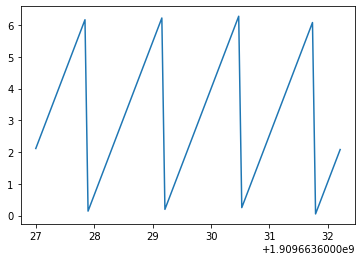

In [14]:
# Plot HWP angle vs time for observation 7
times = data.obs[7].shared["times"]
hwp = data.obs[7].shared["hwp_angle"]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(times.data[:100], hwp.data[:100])

plt.show()

The `Observation` class also gives us access to the focalplane properties for this observation:

In [15]:
# The telescope for this observation
print(data.obs[0].telescope)

<Telescope 'LiteBIRD': uid = 763051199, site = <SpaceSite 'L2' : uid = 3584191102>, focalplane = <Focalplane: 12 detectors, sample_rate = 19.0 Hz, FOV = 20.030803920204306 deg, detectors = [L00_003_QA_040T .. L00_008_UA_040B]>>


In [16]:
# The focalplane
print(data.obs[0].telescope.focalplane)

<Focalplane: 12 detectors, sample_rate = 19.0 Hz, FOV = 20.030803920204306 deg, detectors = [L00_003_QA_040T .. L00_008_UA_040B]>


In [17]:
# The Table of detector properties
print(data.obs[0].telescope.focalplane.detector_data.info)
print(data.obs[0].telescope.focalplane.detector_data)

<QTable length=12>
     name       dtype  shape   unit    class  
-------------- ------- ----- -------- --------
          name bytes16                  Column
          quat float64  (4,)            Column
   pol_leakage float64                  Column
          fwhm float64         arcmin Quantity
      psd_fmin float64             Hz Quantity
     psd_fknee float64             Hz Quantity
     psd_alpha float64                  Column
       psd_net float64       K s(1/2) Quantity
    bandcenter float64            GHz Quantity
     bandwidth float64            GHz Quantity
         pixel  bytes4                  Column
       pixtype  bytes4                  Column
         wafer  bytes4                  Column
     telescope  bytes4                  Column
          band  bytes7                  Column
           pol  bytes2                  Column
        handed  bytes2                  Column
        orient  bytes2                  Column
           uid  uint64                  C

## Simulating Detector Signal

When simulating detector data, we can accumulate signal from many sources, and also introduce systematics along the way.

### Dipole

For a simple sky signal component, we could start with a solar dipole.

In [18]:
sim_dipole = toast.ops.SimDipole(
    freq=40.0 * u.GHz,
    mode="solar",
)
sim_dipole.apply(data)

Now we can see what was created in the first observation:

In [19]:
print(data.obs[0])

<Observation
  name = 'LB_000000_2030-07-07T07:07+00:00_1909638427'
  uid = '606777389'  group has 1 processes
  telescope = <Telescope 'LiteBIRD': uid = 763051199, site = <SpaceSite 'L2' : uid = 3584191102>, focalplane = <Focalplane: 12 detectors, sample_rate = 19.0 Hz, FOV = 20.030803920204306 deg, detectors = [L00_003_QA_040T .. L00_008_UA_040B]>>
  68400 total samples (68400 local)
  shared:  <SharedDataManager
    times: shape = (68400,), dtype = float64
    flags: shape = (68400,), dtype = uint8
    position: shape = (68400, 3), dtype = float64
    velocity: shape = (68400, 3), dtype = float64
    boresight_radec: shape = (68400, 4), dtype = float64
    hwp_angle: shape = (68400,), dtype = float64>
  detdata:  <DetDataManager 12 local detectors, 68400 samples
    signal: shape = (12, 68400), dtype = float64>
  intervals:  <IntervalsManager 0 lists>
>


Notice that the "detdata" attribute now has an item called "signal", which has 12 detector timestreams.  The dipole timestream we simulated is in Kelvin, but let's work in
uK instead.  We can modify the data in place:

In [20]:
for ob in data.obs:
    ob.detdata["signal"][:, :] *= 1e6

### Gain Drifts

Now let us introduce a systematic effect- a small gain drift across all detectors.  In this case we apply a thermal drift across our wafer. In order to plot the effect, we can copy the original signal to another detdata object.

In [21]:
toast.ops.Copy(detdata=[("signal", "dipole")]).apply(data)

Now apply the gain drifts:

In [22]:
gain_drifter = toast.ops.GainDrifter(
    drift_mode="slow_drift",
    focalplane_group="wafer",
    #thermal_fluctuation_amplitude=0.2 * u.K,
)
gain_drifter.apply(data)

Plot the difference for one detector in one observation:

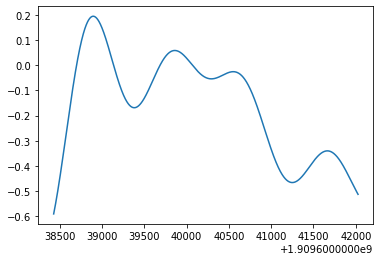

In [23]:
times = data.obs[0].shared["times"]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(
    times.data, 
    (
        data.obs[0].detdata["signal"]["L00_003_QA_040T"] -
        data.obs[0].detdata["dipole"]["L00_003_QA_040T"]
    )
)

plt.show()

### Instrumental Noise

Now we can simulate another component and accumulate that.  Before simulating some instrumental noise, we need to create a "noise model" which describes the noise properties of the detectors.  We could make this by hand with a mixing matrix that included correlations between detectors.  For now, we will use a small operator to just create the noise model from the nominal focalplane properties:

In [24]:
# Create an uncorrelated noise model from focalplane detector properties

# (print help for this operator)
#?toast.ops.DefaultNoiseModel

In [25]:
default_model = toast.ops.DefaultNoiseModel(
    noise_model="noise_model" # The string where this will be stored in every observation
)
default_model.apply(data)
print(data.obs[0]["noise_model"])

<AnalyticNoise model with 12 detectors>


Next we create an operator that uses this noise model to simulate timestreams.

In [26]:
# (print help for this operator)
#?toast.ops.SimNoise

In [27]:
# Create it and specify the noise model to use and the detdata name of the output signal

sim_noise = toast.ops.SimNoise(
    noise_model="noise_model",
)
sim_noise.apply(data)

We can now dig deeper into the simulated fake detector signal so far:

In [28]:
print(data.obs[0].detdata["signal"])

<DetectorData 12 detectors each with shape (68400,) and type float64:
  L00_003_QA_040T = [ 2111.771307394088 2485.4084911360537 ... -3814.855346556721 -3072.7393052080984 ]
  L00_003_QA_040B = [ 2052.72661947656 2135.3628786962286 ... -3170.4809519247087 -3137.0435852323308 ]
  L00_004_QB_040T = [ 1487.4059541355919 1747.4848488176895 ... -3274.4451957151477 -3921.6212488565175 ]
  L00_004_QB_040B = [ 2029.6229747894984 2042.6434119720457 ... -3574.536575860223 -3162.4075202289314 ]
  L00_005_UA_040T = [ 2268.502683449272 1541.0763137956337 ... -2236.4450940714514 -1993.5458166915773 ]
  L00_005_UA_040B = [ 1188.7866076716246 2743.498255095942 ... -3891.388210802721 -2638.5928392854657 ]
  L00_006_UA_040T = [ 2924.5224891979606 2055.375918314568 ... -3305.5159361671945 -2470.648091576346 ]
  L00_006_UA_040B = [ 1991.2654711460593 3001.8760176561727 ... -2145.984143704978 -3485.1491749086103 ]
  L00_007_UB_040T = [ 3773.0080316006015 2457.1119962837597 ... -2817.0442455642833 -2320.036

This `DetectorData` object allows us to access the data by detector name, detector index, or sample range:

In [29]:
signal = data.obs[0].detdata["signal"]

In [30]:
print(signal["L00_003_QA_040T"])

[ 2111.77130739  2485.40849114  2080.20742994 ... -3340.70241997
 -3814.85534656 -3072.73930521]


In [31]:
print(signal[["L00_003_QA_040T", "L00_004_QB_040T"], 0:4])

[[2111.77130739 2485.40849114 2080.20742994 2480.62172629]
 [1487.40595414 1747.48484882 2207.00412029 1940.22229438]]


In [32]:
# The whole thing...
print(signal[:, :])

[[ 2111.77130739  2485.40849114  2080.20742994 ... -3340.70241997
  -3814.85534656 -3072.73930521]
 [ 2052.72661948  2135.3628787   2430.52362894 ... -2331.57928895
  -3170.48095192 -3137.04358523]
 [ 1487.40595414  1747.48484882  2207.00412029 ... -2746.35789448
  -3274.44519572 -3921.62124886]
 ...
 [ 2133.04262976  2309.22191522  2303.06327757 ... -2569.78667702
  -3511.21860902 -2830.49916913]
 [ 2384.74141634  2404.66532416  2324.583139   ... -2550.77529607
  -2607.4726403  -3469.60001114]
 [ 2601.69474335  1565.42706549  2175.81005473 ... -3774.86260802
  -2983.33147303 -2349.57056954]]


The `detdata` attribute of an observation contains just the local data on each process, so you can read and write to these arrays.  One can plot them using the shared timestamps as well:

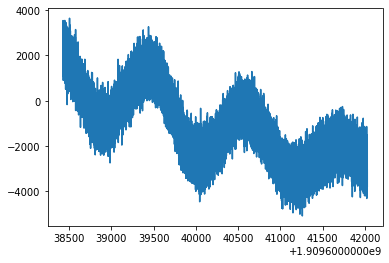

In [33]:
times = data.obs[0].shared["times"]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(times.data, signal["L00_003_QA_040T"])

plt.show()

## Other Operators

You can piece together many other operators to add different types of signal and systematics, etc.  These can be covered in later notebooks.

## Map Making

Here we show a simple example of mapmaking.  First, we need to create several operators that we will pass to the map maker (which will apply the operators internally).  We begin with the pointing information.  The low-level "detector pointing" operator maps telescope boresight quaternions to detector quaternions.  The "pointing matrix" has 2 parts, the sky pixels and the Stokes weights:

In [34]:
# The default detector pointing operator just takes the focalplane offset from
# the boresight and applies it to boresight pointing

det_pointing = toast.ops.PointingDetectorSimple()
# Operator traits can be set in the constructor, or afterwards.  The default "names"
# for the different objects in the Observation can be set per-experiment globally,
# and we can also get the traits from earlier operators in the workflow and use
# them in later ones:
det_pointing.boresight = sim_scan.boresight

# This operator defines the sky pixels
pixels = toast.ops.PixelsHealpix(
    nside=512,
    detector_pointing=det_pointing
)

# These are the Stokes weights.  Notice we set some traits in the
# constructor- we could also set these aftwards if we wanted.
weights = toast.ops.StokesWeights(
    mode="IQU",
    hwp_angle=sim_scan.hwp_angle,
    detector_pointing=det_pointing
)

Next we need a "binning" operator that will be used during the template amplitude solving and also the final map binning.  The mapmaker accepts different binning operators for these two steps, but here we use the same one.

Here we demonstrate a useful technique:  If you have a previous operator configured with particular traits (in this case the name of the noise model in the observations), you can access that and pass it to other operators.

In [35]:
# Set up binning operator for solving and final map.  Again,
# this is just creating the operator, not actually doing
# anything yet.
binner = toast.ops.BinMap(
    pixel_pointing=pixels,
    stokes_weights=weights,
    noise_model=default_model.noise_model,
)

Now we set up the templates we will use in our map making.  In this case we will use a single template for offset amplitudes (destriping baselines).  After configuring our templates, we add them to a template matrix operator:

In [36]:
# Set up template matrix with just an offset template.

tmpl = toast.templates.Offset(
    times=sim_scan.times,
    noise_model=default_model.noise_model,
    step_time=5.0 * u.second,
)
tmatrix = toast.ops.TemplateMatrix(templates=[tmpl])

### Low Memory Use

Finally we are ready to create our Mapmaking operator and run it.  This will be **slow**, since by default we are not saving the pointing.  So every iteration of the solver we are re-generating the pixel number and Stokes weights for every sample, for every detector.  We are also doing this using a single process in this notebook.

In [37]:
# Map maker set up

# Where the maps should be written
output_dir = "."

mapper = toast.ops.MapMaker(
    name="mapmaker", # This name will prefix all the output products.
    det_data="signal", # The name of the detector data we simulated
    binning=binner,
    template_matrix=tmatrix,
    solve_rcond_threshold=1.0e-6,
    map_rcond_threshold=1.0e-6,
    iter_max=10,
    output_dir=output_dir
)

# Make the map
mapper.apply(data)

TOAST INFO: MapMaker begin building flags for solver
TOAST INFO: MapMaker  finished flag building in 0.01 s
TOAST INFO: MapMaker begin build of solver covariance
TOAST INFO: MapMaker  finished build of solver covariance in 10.33 s
TOAST INFO: MapMaker Solver flags cut 0 / 19699200 = 0.00% of samples
TOAST INFO: MapMaker begin RHS calculation
TOAST INFO: MapMaker  finished RHS calculation in 7.77 s
TOAST INFO: MapMaker begin PCG solver
TOAST INFO: MapMaker initial residual = 37630.60316637864, 7.62 s
TOAST INFO: MapMaker iteration    0, relative residual = 6.639905e-02, 8.20 s
TOAST INFO: MapMaker iteration    1, relative residual = 4.349527e-02, 8.17 s
TOAST INFO: MapMaker iteration    2, relative residual = 4.105895e-02, 7.93 s
TOAST INFO: MapMaker iteration    3, relative residual = 3.253614e-02, 7.67 s
TOAST INFO: MapMaker iteration    4, relative residual = 3.032933e-02, 11.31 s
TOAST INFO: MapMaker iteration    5, relative residual = 3.068060e-02, 8.07 s
TOAST INFO: MapMaker itera

Note that because we have added a gain drift and not mitigated it, the solver did not converge.  You can comment out the gain drift above and re-run to see how it converges.  Now we can read our outputs and plot them.  Note that our timestream has the dipole in it still, which we would normally use for calibration and remove. 

/home/kisner/software/cmbenv/cmbenv_aux/lib/python3.9/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 512
  warnings.warn("NSIDE = {0:d}".format(nside))
/home/kisner/software/cmbenv/cmbenv_aux/lib/python3.9/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/kisner/software/cmbenv/cmbenv_aux/lib/python3.9/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))
/home/kisner/software/cmbenv/cmbenv_aux/lib/python3.9/site-packages/healpy/fitsfunc.py:486: UserWarning: Ordering converted to RING
  warnings.warn("Ordering converted to RING")
/home/kisner/software/cmbenv/cmbenv_aux/lib/python3.9/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colorm

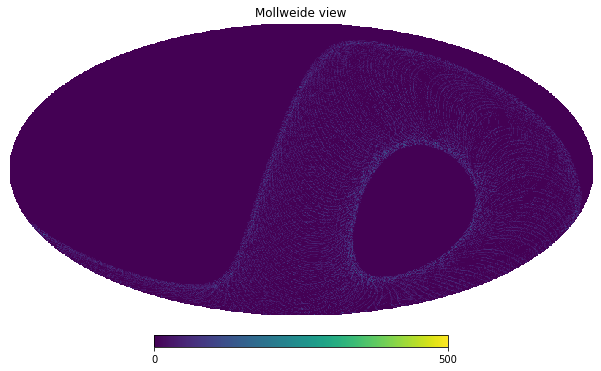

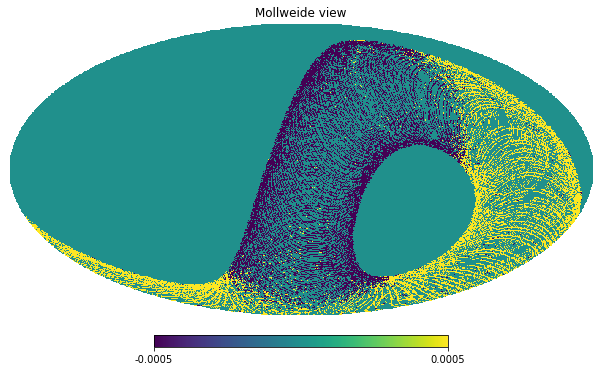

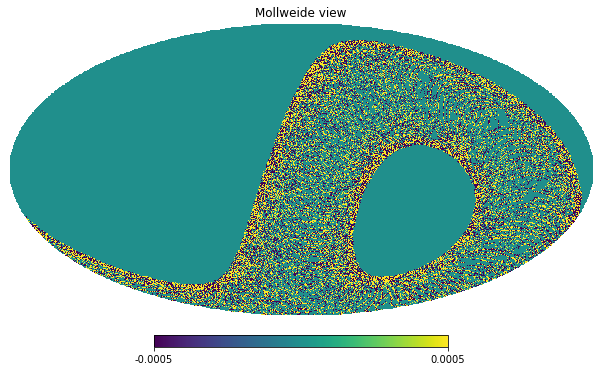

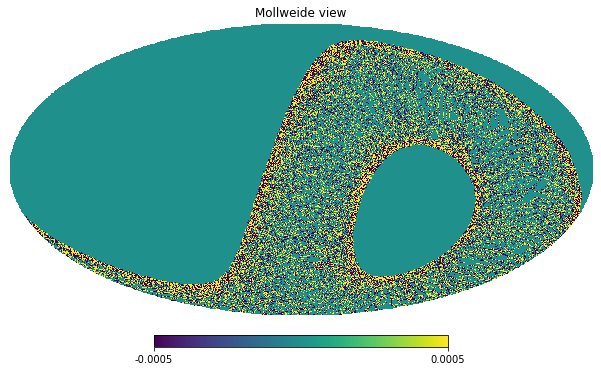

In [38]:
mapfile_root = os.path.join(output_dir, mapper.name)

hits = hp.read_map(
    f"{mapfile_root}_hits.fits", 
    dtype=np.int32
)
hp.mollview(hits, min=0, max=500)

Imap, Qmap, Umap = hp.read_map(
    f"{mapfile_root}_map.fits", 
    field=None
)
hp.mollview(Imap, min=-0.0005, max=0.0005)
hp.mollview(Qmap, min=-0.0005, max=0.0005)
hp.mollview(Umap, min=-0.0005, max=0.0005)

### Larger Memory Use and Faster

If we have enough memory, we can compute the pointing once and save it.  Check how much memory we are using right now:

In [39]:
# Reset the counter first...
mem_count.total_bytes = 0
mem_count.apply(data)

TOAST INFO: :  Total timestream memory use = 0.595 GB
TOAST INFO: :  Memory usage (whole node)
       total :   62.555 GB
   available :   53.220 GB
     percent :   14.900 % 
        used :    8.613 GB
        free :   48.570 GB
      active :    2.196 GB
    inactive :   10.610 GB
     buffers :  363.148 MB
      cached :    5.018 GB
      shared :  225.656 MB
        slab :  486.207 MB



638582400

OK, now we can generate the pointing once for the whole dataset:

In [40]:
pixels.apply(data)
weights.apply(data)

In [41]:
# Check memory use now
mem_count.total_bytes = 0
mem_count.apply(data)

TOAST INFO: :  Total timestream memory use = 1.671 GB
TOAST INFO: :  Memory usage (whole node)
       total :   62.555 GB
   available :   52.085 GB
     percent :   16.700 % 
        used :    9.749 GB
        free :   47.435 GB
      active :    2.196 GB
    inactive :   11.736 GB
     buffers :  363.203 MB
      cached :    5.016 GB
      shared :  224.281 MB
      shared :  225.047 MB (after GC)
        slab :  486.000 MB



1794268800

Now re-run the mapmaking and write the outputs to a different name:

In [42]:
mapper.name = "example2"
mapper.apply(data)

TOAST INFO: MapMaker begin building flags for solver
TOAST INFO: MapMaker  finished flag building in 0.01 s
TOAST INFO: MapMaker begin build of solver covariance
TOAST INFO: MapMaker  finished build of solver covariance in 5.30 s
TOAST INFO: MapMaker Solver flags cut 0 / 19699200 = 0.00% of samples
TOAST INFO: MapMaker begin RHS calculation
TOAST INFO: MapMaker  finished RHS calculation in 1.16 s
TOAST INFO: MapMaker begin PCG solver
TOAST INFO: MapMaker initial residual = 37630.60316637864, 1.51 s
TOAST INFO: MapMaker iteration    0, relative residual = 6.639905e-02, 1.35 s
TOAST INFO: MapMaker iteration    1, relative residual = 4.349527e-02, 1.22 s
TOAST INFO: MapMaker iteration    2, relative residual = 4.105895e-02, 1.35 s
TOAST INFO: MapMaker iteration    3, relative residual = 3.253614e-02, 1.09 s
TOAST INFO: MapMaker iteration    4, relative residual = 3.032933e-02, 1.03 s
TOAST INFO: MapMaker iteration    5, relative residual = 3.068060e-02, 1.22 s
TOAST INFO: MapMaker iterati

So here we see that it runs much faster.